In [ ]:
# instalação do Weights & Biases
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00


In [ ]:
# Importação das bibliotecas
import wandb
import pandas as pd
import numpy as np
import tempfile
import logging
import os
import math
from google.colab import drive
from zipfile import ZipFile
from PIL import Image
import matplotlib.pyplot as plt

# Pegando artefatos do wandb

In [ ]:
# wandb login
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# inicializando uma run no wandb
run = wandb.init(project="Breast Cancer TCC", job_type="preprocess")

wandb: Currently logged in as: valmirfrancisco1. Use `wandb login --relogin` to force relogin


In [ ]:
# Pegando o CSV com a informação das imagens
artifact = run.use_artifact('valmirfrancisco1/Breast Cancer TCC/label_data:latest', type='raw_data').file()

df = pd.read_csv(artifact)

# Verificando valores NaN

In [ ]:
# pegando colunas
col = df.columns

# armazena a quantidade de nulos por categoria em um array
nulls = []
for i in col:
  x = df[i].isnull().sum()
  nulls.append(x)

# dataset de colunas por nulos
data = {'Colunas': col,
        'Nulos': nulls}
col_nulls = pd.DataFrame(data)
col_nulls

,Colunas,Nulos
0,site_id,0
1,patient_id,0
2,image_id,0
3,laterality,0
4,view,0
5,age,37
6,cancer,0
7,biopsy,0
8,invasive,0
9,BIRADS,28420


As colunas que tiveram dados nulos foram Age (37), BIRADS (28420) e density (25236)

Descrição
- Age: Idade do paciente em anos.
- Density: Uma classificação da densidade do tecido mamário, sendo A o menos denso e D o mais denso. Tecido extremamente denso pode dificultar o diagnóstico.
- BIRADS: 0 se a mama necessitar de acompanhamento, 1 se a mama for classificada como negativa para câncer e 2 se a mama for classificada como normal.

Por conta da alta quantidade de valores nulos irei remover as colunas de Birads e Densidade. Idade por ter apenas 37 nulos em mais de 50 mil irei utilizar a média da coluna nos valores nulos.

In [ ]:
df = df.drop(["BIRADS", "density"], axis="columns")
df

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,implant,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,0,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,0,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,0,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,0,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0,21,True
...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,43.0,0,0,0,0,49,False
54702,1,9989,63473691,L,MLO,60.0,0,0,0,0,216,False
54703,1,9989,1078943060,L,CC,60.0,0,0,0,0,216,False
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0,216,True


In [ ]:
# descobrir a média de age da tabela
media = math.floor(df["age"].mean())
media
df["age"].fillna(media, inplace=True)

In [ ]:
# pegando colunas
col = df.columns

# armazena a quantidade de nulos por categoria em um array
nulls = []
for i in col:
  x = df[i].isnull().sum()
  nulls.append(x)

# dataset de colunas por nulos
data = {'Colunas': col,
        'Nulos': nulls}
col_nulls = pd.DataFrame(data)
col_nulls

,Colunas,Nulos
0,site_id,0
1,patient_id,0
2,image_id,0
3,laterality,0
4,view,0
5,age,0
6,cancer,0
7,biopsy,0
8,invasive,0
9,implant,0


# Excluindo linhas duplicadas do dataset

In [ ]:
# número de linhas antes da remoção
len(df)

54706

In [ ]:
# Deletando linhas duplicatas
df.reset_index()
df.drop_duplicates(inplace=True)

In [ ]:
# número de linhas após a remoção
len(df)

54706

### Não existem valores duplicados, então não temos nenhuma remoção

# Transformando valores categóricos em valores numéricos

In [ ]:
df

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,implant,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,0,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,0,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,0,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,0,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0,21,True
...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,43.0,0,0,0,0,49,False
54702,1,9989,63473691,L,MLO,60.0,0,0,0,0,216,False
54703,1,9989,1078943060,L,CC,60.0,0,0,0,0,216,False
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0,216,True


### Temos 3 colunas com valores não categóricos

- Laterality: Se a imagem é da mama esquerda ou direita.
- View: A orientação da imagem. O padrão para um exame de triagem é capturar duas visualizações por mama.
- Difficult_negative_case: É verdade se o caso for extraordinariamente difícil.

In [ ]:
# verificando o tipo dos valores do dataframe
df.dtypes

site_id                      int64
patient_id                   int64
image_id                     int64
laterality                  object
view                        object
age                        float64
cancer                       int64
biopsy                       int64
invasive                     int64
implant                      int64
machine_id                   int64
difficult_negative_case       bool
dtype: object

## Transformando valores object do dataframe em inteiro

In [ ]:
# função usada para transformar uma coluna de valor categórico em númerico
def Encoder(val):
  # Retorna o valor numérico correspondente ao valor da linha.
  # val: o valor daquela linha.
  # Retorna: O valor numérico correspondente a `val` usando a ordem de encontro na linha

  # Verifica se o valor da linha já está no dicionário.
  if val in category:
    # Se sim, retorne o valor numérico correspondente ao valor da linha.
    return category[val]
  # Caso contrário, adicione o valor da linha ao dicionário e retorne o novo valor numérico.
  else:
    category[val]=len(category)
  return category[val]

In [ ]:
col = ["laterality", "view", "difficult_negative_case"]
category_array = []
for i in col:
    category={}
    # Chama a função do codificador para converter valores categóricos em valores numéricos.
    df[i]=df[i].apply(Encoder)
    category_array.append(category)

df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,implant,machine_id,difficult_negative_case
0,2,10006,462822612,0,0,61.0,0,0,0,0,29,0
1,2,10006,1459541791,0,1,61.0,0,0,0,0,29,0
2,2,10006,1864590858,1,1,61.0,0,0,0,0,29,0
3,2,10006,1874946579,1,0,61.0,0,0,0,0,29,0
4,2,10011,220375232,0,0,55.0,0,0,0,0,21,1


### Lista com as substituições feitas nessa etapa

In [ ]:
category_array[0]

{'L': 0, 'R': 1}

In [ ]:
category_array[1]

{'CC': 0, 'MLO': 1, 'ML': 2, 'LM': 3, 'AT': 4, 'LMO': 5}

In [ ]:
category_array[2]

{False: 0, True: 1}

## Mudando o valor da coluna Age para inteiro

In [ ]:
df["age"] = df["age"].astype(int)
print(df["age"].dtypes)

int64


In [ ]:
df.dtypes

site_id                    int64
patient_id                 int64
image_id                   int64
laterality                 int64
view                       int64
age                        int64
cancer                     int64
biopsy                     int64
invasive                   int64
implant                    int64
machine_id                 int64
difficult_negative_case    int64
dtype: object

# Procurando outliers

In [ ]:
df

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,implant,machine_id,difficult_negative_case
0,2,10006,462822612,0,0,61,0,0,0,0,29,0
1,2,10006,1459541791,0,1,61,0,0,0,0,29,0
2,2,10006,1864590858,1,1,61,0,0,0,0,29,0
3,2,10006,1874946579,1,0,61,0,0,0,0,29,0
4,2,10011,220375232,0,0,55,0,0,0,0,21,1
...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,1,1,43,0,0,0,0,49,0
54702,1,9989,63473691,0,1,60,0,0,0,0,216,0
54703,1,9989,1078943060,0,0,60,0,0,0,0,216,0
54704,1,9989,398038886,1,1,60,0,0,0,0,216,1


In [ ]:
# caso todas as colunas tenham a quantidade de valores diferentes esperado não deve printar nada
binary_column = ["site_id", "cancer", "biopsy", "invasive", "implant", "difficult_negative_case"]
for i in binary_column:
  n = df[i].nunique()
  if(n > 2):
    print(f"a coluna {i} tem valores fora da faixa esperada")

## verificando os valores da coluna age

In [ ]:
max = df["age"].max()
min = df["age"].min()
print(f"o valor máxino da coluna é {max}, e o mínimo é {min}")

o valor máxino da coluna é 89, e o mínimo é 26


# Equilibrando a quantidade de valores negativos e positivos na coluna câncer

In [ ]:
filter = df["cancer"] == 1
df_positive = df[filter]
n_positive = df_positive.shape[0]
df_positive.reset_index(drop=True, inplace=True)

In [ ]:
filter = df["cancer"] == 0
df_negative = df[filter]
df_negative.reset_index(drop=True, inplace=True)

In [ ]:
import random
random.seed(2141301728)
df_final = pd.DataFrame()
for i in range(0, df_positive.shape[0]):
  n = random.randint(0, df_negative.shape[0])
  x = df_negative.loc[n]
  df_final = pd.concat([df_final, x.to_frame().T])
  df_negative = df_negative.drop(index=n)
  df_negative.reset_index(drop=True, inplace=True)

In [ ]:
df_final = pd.concat([df_final, df_positive])
df_final.reset_index(drop=True, inplace=True)
df_final

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,implant,machine_id,difficult_negative_case
0,1,20480,500020227,0,1,69,0,0,0,0,49,0
1,2,46958,1950878578,1,0,65,0,0,0,0,29,0
2,1,46760,674972431,0,1,77,0,0,0,0,49,0
3,2,11753,1642742026,0,0,57,0,0,0,0,29,0
4,2,9726,1032137434,0,1,66,0,0,0,0,21,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2311,2,9707,1900919592,1,1,56,1,1,1,0,21,0
2312,2,9840,111786935,1,1,59,1,1,1,0,21,0
2313,2,9840,1559360810,1,0,59,1,1,1,0,21,0
2314,2,9851,1409270544,0,1,58,1,1,0,0,48,0


# Buscando imagens

## Acessando drive

In [ ]:
# Download das imagens
drive.mount('/content/gdrive')
path_arquive_zip = "/content/gdrive/MyDrive/TCC/data/archive.zip"
destination_folder = "/content/destination/"

# certifica a existência da pasta de destino
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# abre e extrai o arquivo zip para o seu destino
with ZipFile(path_arquive_zip, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

print("arquivo .zip descompactado com sucesso.")

Mounted at /content/gdrive
arquivo .zip descompactado com sucesso.


In [ ]:
# verificando o número de imagens e de linhas do csv original
arquivos = os.listdir("/content/destination/")
n_arquivos = len(arquivos)
qtd_linhas = df.shape[0]
if (n_arquivos == qtd_linhas):
  print("mesmo número de imagens e linhas")

mesmo número de imagens e linhas


## Adicionando os dados em um formato armazenavel na nossa plataforma de artefatos

In [ ]:
# arrays onde iremos colocar os dados das imagens e os seus rótulos
img_data = []
cancer = pd.DataFrame()

In [ ]:
for img in os.listdir(destination_folder):
  # Adicionando os valores da imagem
  img_part = img.split("_", 1)
  image_id = int(img_part[1].split(".")[0])
  filter = df_final["image_id"] == image_id
  cancer_value = df_final.loc[filter]

  if cancer_value.empty:
    continue
  else:
    cancer = pd.concat([cancer, cancer_value])
    # Adicionando as imagens
    im_path = os.path.join(destination_folder, img)
    with Image.open(im_path) as im:
      im = im.resize((224, 224))
      im = im.convert('RGB')
      im = np.array(im, dtype='float32') / 255
      img_data.append(im)

In [ ]:
if (len(img_data) == len(cancer)):
  print("valores equivalentes nas listas")

valores equivalentes nas listas


## Salvando os dados das imagens em um arquivo numpy

In [ ]:
# salvando o array no formato de um arquivo numpy
np.save('img_data.npy', img_data)

### Pegando os dados de volta de um arquivo numpy

In [ ]:
# carregando os dados do arquivo numpy na variável loaded_data
loaded_data = np.load('img_data.npy', allow_pickle=True)

# print do loaded data
print(loaded_data)

[[[[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  ...

  [[0.99607843 0.99607843 0.99607843]
   [0.99607843 0.99607843 0.99607843]
   [0.99607843 0.99607843 0.99607843]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[1.         1.         1.        ]
   [1. 

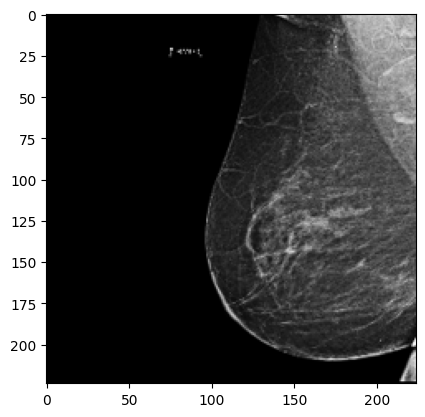

In [ ]:
# número aleatório usado para confirmar se a conversão foi feita de forma correta
n = random.randint(0, len(img_data))
# imagem do array original
plt.imshow(img_data[n])

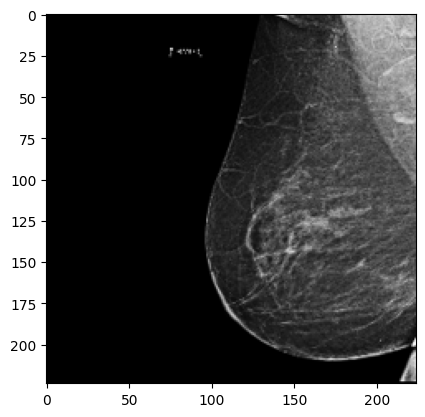

In [ ]:
# imagem do array carregado do arquivo numpy
plt.imshow(loaded_data[n])

# Enviando os dados limpos para o wandb

## Preparando arquivos para enviar ao wandb

In [ ]:
# salvando o dataframe
cancer.to_csv("label_data.csv", index=False)

In [ ]:
# salvando arquivo de imagens
np.save('img_data.npy', img_data)
loaded_data = np.load('img_data.npy')

## Enviando para o wandb

In [ ]:
# criando um artefato no wandb
artifact = wandb.Artifact(name="img_data_clean",
                                  type="clean_data",
                                  description="data from the imagens")

# adiciona o arquivo no artefato
artifact.add_file("img_data.npy")
# salva o artefato no wandb
wandb.run.log_artifact(artifact)

# criando um artefato no wandb
artifact2 = wandb.Artifact(name="label_data_clean",
                                  type="clean_data",
                                  description="data from the labels")

# adiciona o arquivo no artefato
artifact2.add_file('label_data.csv')

# salva o artefato no wandb
wandb.run.log_artifact(artifact2)

<Artifact label_data_clean>

In [ ]:
# termina a run
run.finish()